In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import numpy as np
import pandas as pd
import admix
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import seaborn as sns
import os
import dapgen
from os.path import join
import admix_genet_cor

In [2]:
GENO_DIR = (
    "/u/project/pasaniuc/pasaniucdata/admixture/projects/PAGE-QC/01-dataset/out/aframr"
)

In [3]:
pfile = f"{GENO_DIR}/imputed/chr1"
dset = admix.io.read_dataset(pfile, snp_chunk=512)

dset = dset[
    (
        dset.snp.EUR_FREQ.between(0.005, 0.995)
        & dset.snp.AFR_FREQ.between(0.005, 0.995)
    ).values
]

2022-01-21 15:57.49 [info     ] admix.Dataset: read local ancestry from /u/project/pasaniuc/pasaniucdata/admixture/projects/PAGE-QC/01-dataset/out/aframr/imputed/chr1.lanc
2022-01-21 15:57.58 [info     ] admix.Dataset: `n_anc` is not provided, infered n_anc from the first 1,000 SNPs is 2. If this is not correct, provide `n_anc` when constructing admix.Dataset


Find `n_region=30` regions, select the center SNP as the causal SNP, select 800 SNPs in the +- 10k SNPs, every 25 SNPs, and calculate the covariance difference.

In [4]:
window_size = 10000
step_size = 25
n_region = 30

In [5]:
apa = dset.allele_per_anc()
geno_cnt = dset.geno.sum(axis=2)

In [6]:
np.random.seed(1234)
causal_snps = np.random.choice(dset.snp.index, size=n_region, replace=False)
causal_idx = [dset.snp.index.get_loc(s) for s in causal_snps]

df_cov_diff = {"cov_diff": [], "ex_diff": [], "pos": [], "causal_snp": []}

for snp, idx in zip(causal_snps, causal_idx):
    region_idx = np.arange(idx - window_size, idx + window_size, step_size)
    z_list, ex_list = admix_genet_cor.calc_apa_cov(
        apa[region_idx, :, :].compute(),
        geno_cnt[idx, :].compute(),
    )
    df_cov_diff["cov_diff"].extend(z_list)
    df_cov_diff["ex_diff"].extend(ex_list[:, 0] - ex_list[:, 1])
    # relative base pairs
    df_cov_diff["pos"].extend(
        (dset.snp.POS.iloc[region_idx] - dset.snp.POS.iloc[idx]).values
    )
    df_cov_diff["causal_snp"].extend([snp] * len(region_idx))
    break
df_cov_diff = pd.DataFrame(df_cov_diff)

100%|██████████| 800/800 [00:01<00:00, 697.73it/s]


In [41]:
# alternative way to calculate LD
admix_ld = admix.data.admix_ld(dset[region_idx])

def GG(admix_ld, i, j):
    """
    Obtain
    gi1 x gj1, gi1 x gj2
    gj1 x gi2, gi2 x gj2

    Note that the matrix is not symmetric
    """
    ld1, ld2, ld12 = admix_ld["11"], admix_ld["22"], admix_ld["12"]
    return np.array([[ld1[i, j], ld12[i, j]], [ld12[j, i], ld2[i, j]]])

center_i = np.where(idx == region_idx)[0].item()

res = []
for i in range(len(region_idx)):
    GiGi = GG(admix_ld, i, i)
    GiGj = GG(admix_ld, i, center_i)
    tag = np.linalg.inv(GiGi) @ GiGj @ np.ones(2)[:, None]
    res.append(tag.T)
res = np.vstack(res)

In [45]:
ex_list / dset.n_indiv

array([[ 0.04092604, -0.01607983],
       [ 0.0386749 , -0.00474231],
       [ 0.04215021, -0.01192268],
       ...,
       [ 0.05328106, -0.01627517],
       [ 0.03317822, -0.00346181],
       [ 0.01362962, -0.01590849]])

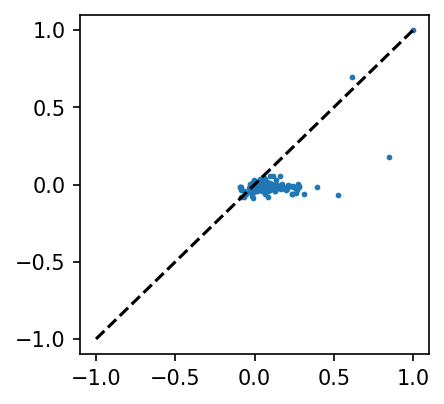

In [35]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
ax.scatter(ex_list[:, 0] / dset.n_indiv, ex_list[:, 1] / dset.n_indiv, s=3)
ax.plot([-1, 1], [-1, 1], "k--")

(array([  4.,   1.,   8.,  23., 120., 417.,  99.,  53.,  39.,   7.,   6.,
          3.,   6.,   2.,   3.,   4.,   1.,   0.,   1.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.]),
 array([-0.08650603, -0.06118869, -0.03587136, -0.01055402,  0.01476332,
         0.04008066,  0.06539799,  0.09071533,  0.11603267,  0.14135001,
         0.16666734,  0.19198468,  0.21730202,  0.24261935,  0.26793669,
         0.29325403,  0.31857137,  0.3438887 ,  0.36920604,  0.39452338,
         0.41984072,  0.44515805,  0.47047539,  0.49579273,  0.52111006,
         0.5464274 ,  0.57174474,  0.59706208,  0.62237941,  0.64769675,
         0.67301409]),
 <BarContainer object of 30 artists>)

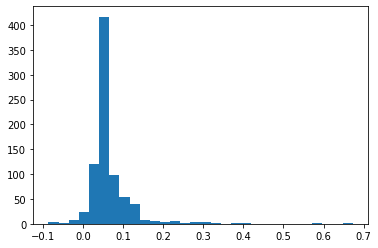

In [48]:
plt.hist((ex_list[:, 0] - ex_list[:, 1]) / dset.n_indiv, bins=30)

(array([ 15., 398., 347.,  35.,   3.,   1.,   0.,   0.,   0.,   1.]),
 array([-281.7769003 ,  -12.87423668,  256.02842694,  524.93109056,
         793.83375419, 1062.73641781, 1331.63908143, 1600.54174505,
        1869.44440867, 2138.34707229, 2407.24973591]),
 <BarContainer object of 10 artists>)

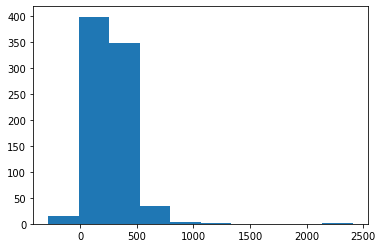

In [25]:
plt.hist(z_list)

In [10]:
df_cov_diff = pd.DataFrame(df_cov_diff)

(array([1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        4.000e+00, 1.000e+00, 3.000e+00, 7.000e+00, 0.000e+00, 0.000e+00,
        6.000e+00, 9.000e+00, 1.700e+01, 1.220e+02, 1.385e+03, 1.545e+03,
        7.780e+02, 4.070e+02, 2.630e+02, 2.000e+02, 1.690e+02, 1.870e+02,
        1.510e+02, 1.250e+02, 1.350e+02, 1.200e+02, 1.090e+02, 9.800e+01,
        8.100e+01, 8.600e+01, 5.100e+01, 5.500e+01, 4.300e+01, 3.200e+01,
        2.600e+01, 2.600e+01, 3.200e+01, 2.300e+01, 1.900e+01, 2.800e+01,
        8.000e+00, 1.200e+01, 1.800e+01, 6.000e+00, 5.000e+00, 3.000e+00,
        1.000e+00, 1.000e+00]),
 array([-2445.19534538, -2300.0608188 , -2154.92629222, -2009.79176565,
        -1864.65723907, -1719.5227125 , -1574.38818592, -1429.25365935,
        -1284.11913277, -1138.98460619,  -993.85007962,  -848.71555304,
         -703.58102647,  -558.44649989,  -413.31197332,  -268.17744674,
         -123.04292016,    22.09160641,   167.22613299,   312.36065956,
          457.49

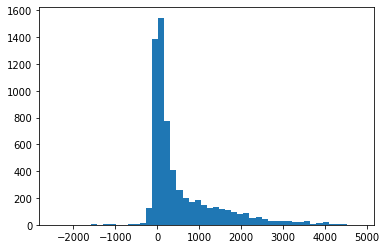

In [19]:
plt.hist(df_cov_diff["cov_diff"], bins=50)

In [11]:
df_plot = df_cov_diff.copy()
# convert to Mb
df_plot["pos"] /= 1e6
df_plot["abs_pos"] = np.abs(df_plot["pos"])
df_plot["squared_cov_diff"] = df_plot["cov_diff"] ** 2
# df_plot = df_plot[df_plot.abs_pos < 6]

In [12]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [13]:
model = smf.quantreg(
    "squared_cov_diff ~ abs_pos + I(abs_pos ** 2.0) + I(abs_pos ** 3.0) ", df_plot
).fit(q=0.95)

Text(0.5, 0, 'Distance (Mb)')

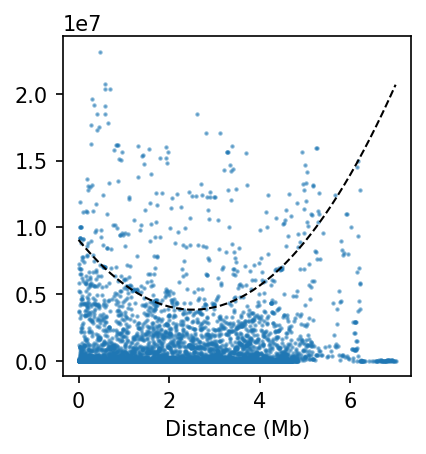

In [14]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
ax.scatter(
    df_plot.abs_pos,
    df_plot.squared_cov_diff,
    marker=".",
    alpha=0.5,
    s=5,
)
x_grid = np.linspace(0, df_plot.abs_pos.max(), 50)


plt.plot(
    x_grid,
    model.predict({"abs_pos": x_grid}),
    linestyle="--",
    lw=1,
    color="k",
    zorder=2,
)
ax.set_xlabel("Distance (Mb)")

In [ ]:
# select a 10 Mb region
# simulate a single causal (with expected p-value of 1e-10)
# perform study

In [ ]:
# causal_snp = "chr1:109593836:A:G"
# causal_snp = "chr1:11472468:C:G"
causal_snp = "chr1:229573921:C:A"
hsq = 0.005

In [ ]:
def submit_simulate_pheno(
    hsq,
    causal_snp,
    region_window=500,
    #     out_prefix: str,
    #     n_sim=10,
):
    """
    hsq: heritability of the causal SNPs.
    causal_snp: index of the causal SNP
    region_window: window size in Mb
    """
    np.random.seed(0)
    pfile = f"{GENO_DIR}/imputed/chr1"
    geno, df_snp, df_indiv = dapgen.read_pfile(pfile, phase=True, snp_chunk=2048)
    lanc = admix.io.read_lanc(pfile + ".lanc", snp_chunk=2048)
    df_snp_info = pd.read_csv(pfile + ".snp_info", sep="\t").set_index("SNP")
    assert np.all(df_snp_info.index == df_snp.index.values)
    df_snp = pd.merge(df_snp, df_snp_info, left_index=True, right_index=True)

    # determine subset of SNPs
    causal_idx = df_snp.index.get_loc(causal_snp)

    region_snp_idx = np.arange(
        causal_idx - region_window, causal_idx + region_window + 1
    )
    df_tmp = df_snp.iloc[region_snp_idx, :]
    freq_filter = (
        (0.005 <= df_tmp.EUR_FREQ)
        & (df_tmp.EUR_FREQ <= 0.995)
        & (0.005 <= df_tmp.AFR_FREQ)
        & (df_tmp.AFR_FREQ <= 0.995)
    )
    region_snp_idx = region_snp_idx[freq_filter]

    geno = geno[region_snp_idx, :, :]
    lanc = lanc[region_snp_idx, :, :]
    df_snp = df_snp.iloc[region_snp_idx, :]

    n_eff_snp = df_snp.shape[0]

    beta = np.zeros((n_eff_snp, 2, 1))  # (n_snp, n_anc, n_sim)
    causal_idx = df_snp.index.get_loc(causal_snp)

    beta[causal_idx, :, :] = 1.0

    sim = admix_genet_cor.simulate_quant_pheno(
        geno=geno, lanc=lanc, hsq=hsq, beta=beta, n_sim=1
    )
    pheno = sim["pheno"].flatten()
    df_rls = admix_genet_cor.marginal_het(
        geno=geno,
        lanc=lanc,
        y=pheno,
    )

    # calculate covariance
    apa = admix.data.allele_per_anc(geno, lanc, n_anc=2).compute()
    geno_cnt = geno.sum(axis=2).compute()

    df_rls["cov_diff_z"] = admix_genet_cor.calc_apa_cov(apa, geno_cnt[causal_idx, :])

    df_rls["total_cov"] = admix_genet_cor.calc_cov(
        geno_cnt, geno_cnt[[causal_idx], :]
    ).flatten()

    df_rls["assoc_pval"] = admix.assoc.marginal_fast(
        geno=geno, lanc=lanc, pheno=pheno, cov=None
    )
    causal_mask = np.full(df_rls.shape[0], False, dtype=bool)
    causal_mask[causal_idx] = True
    df_rls["causal"] = causal_mask
    #     return df_rls

    return df_rls, df_snp, apa, pheno

In [ ]:
df_rls, df_snp, apa, pheno = submit_simulate_pheno(hsq=0.05, causal_snp=causal_snp)

In [ ]:
plt.scatter(np.arange(len(df_rls)), df_rls["cov_diff_z"] ** 2)

In [ ]:
plt.scatter(df_rls["cov_diff_z"] ** 2, -np.log10(df_rls["het_pval"]))

In [ ]:
fig, ax = plt.subplots(dpi=150)
admix.plot.manhattan(df_rls.assoc_pval)

In [ ]:
fig, ax = plt.subplots(dpi=150)
admix.plot.manhattan(df_rls.het_pval)

In [ ]:
df_rls[df_rls["causal"]]

In [ ]:
n_snp = apa.shape[0]
assert apa.shape[1] == m.shape[0]
# center apa
apa = apa - apa.mean(axis=0)[None, :, :]
m = m - m.mean()

z_list = np.zeros(n_snp)
# for each snp, calculate the covariance
transform_vec = np.array([[1], [-1]])
for snp_i in range(apa.shape[0]):
    cov_inv = np.linalg.inv(np.cov(apa[snp_i, :, :]))
    # expectation and variance
    ex = cov_inv @ apa[snp_i, :, :].T @ m
    varcov = cov_inv
    z_list[snp_i] = (ex[0] - ex[1]) / np.sqrt(transform_vec @ varcov @ transform_vec.T)
return z_list

In [ ]:
def calc_apa_cov(apa, m):
    # apa: (n_snp, n_indiv, 2)
    # m: (n_indiv, )


In [ ]:
df_rls = submit_simulate_pheno(hsq=0.02, causal_snp=causal_snp)

In [ ]:
plt.scatter(df_rls.cov1 - df_rls.cov2, -np.log10(df_rls.het_pval))

In [ ]:
tmp_snp = [causal_idx, 62]
tmp_apa = apa[62, :, :]

In [ ]:
df_rls.iloc[62, :]

In [ ]:
tmp_apa.shape

In [ ]:
# df_pheno = pd.DataFrame(
#     sim["pheno"],
#     index=df_indiv.index,
#     columns=[f"SIM_{i}" for i in range(n_sim)],
# )
# df_pheno.to_csv(out_prefix + ".pheno.tsv.gz", index=True, sep="\t")

In [ ]:
def submit_gwas(prefix, sim_i):

    df_sample_info = pd.read_csv(
        join(SIM_PHENO_DIR, prefix + ".pheno.tsv.gz"), sep="\t", index_col=0
    )
    out_prefix = f"out/simulated_gwas/{prefix}.sim_{sim_i}"

    admix.tools.plink2.gwas(
        pfile=join(GENO_DIR, f"imputed/chr1"),
        df_sample_info=df_sample_info,
        pheno_col=f"SIM_{sim_i}",
        out_prefix=out_prefix,
        clean_tmp_file=True,
    )
    admix.tools.plink2.clump(
        pfile=join(GENO_DIR, f"imputed/chr1"),
        assoc_path=out_prefix + ".assoc",
        out_prefix=out_prefix,
        p1=5e-8,
    )
    df_sample_info[[f"SIM_{sim_i}"]].rename(columns={f"SIM_{sim_i}": "trait"}).to_csv(
        out_prefix + ".pheno", sep="\t"
    )

In [ ]:
def submit_gwas(prefix, sim_i):

    df_sample_info = pd.read_csv(
        join(SIM_PHENO_DIR, prefix + ".pheno.tsv.gz"), sep="\t", index_col=0
    )
    out_prefix = f"out/simulated_gwas/{prefix}.sim_{sim_i}"

    admix.tools.plink2.gwas(
        pfile=join(GENO_DIR, f"imputed/chr1"),
        df_sample_info=df_sample_info,
        pheno_col=f"SIM_{sim_i}",
        out_prefix=out_prefix,
        clean_tmp_file=True,
    )
    admix.tools.plink2.clump(
        pfile=join(GENO_DIR, f"imputed/chr1"),
        assoc_path=out_prefix + ".assoc",
        out_prefix=out_prefix,
        p1=5e-8,
    )
    df_sample_info[[f"SIM_{sim_i}"]].rename(columns={f"SIM_{sim_i}": "trait"}).to_csv(
        out_prefix + ".pheno", sep="\t"
    )